# Antibodies have different representation based on their interaction with  different targets

##### The purpose of this notebook is to use our trained model to get representation of antibodies given the context of different antigen. Our model can provide distinct representation of antibodies based on their interaction with different target antigens. 

In [1]:
from covbind_esm2_struct import CovBind_ftESM as esm2_struct 
from covbind_esm2_struct import SequenceDataset as esm2_struct_dataset
from Pretrained.ESM2_MLM_Struct.pdb_utilities import get_ca_distance_matrix 

In [2]:
import torch 
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os 
from scipy import stats

In [3]:
df = pd.read_csv('data/model_data_full.csv') 

In [4]:
antibodies_with_multiple_bindings = (
    df.groupby('Antibody')['Target']
    .nunique()  # Count unique values in 'Binding'
    .loc[lambda x: x > 13]  # Filter antibodies with more than one unique value
    .index  # Get the index of filtered results
)

In [5]:
len(antibodies_with_multiple_bindings)

51

`There are 51 antibodies that binds with more than 13 different target antigens. We will get these antibodies' representation from our model.` 

In [ ]:
# Loading the model with pretrained weights 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model_savepath = 'saved_models/covbind_ESM2_Struct_pt.pth' 
model = esm2_struct() 
model.load_state_dict(torch.load(model_savepath, map_location=device), strict=False) 
model = model.to(device)  

In [ ]:
# function to get the antibody embeddings for different target 
def get_embs_for_targets(ab_name):
    df_test = df[df['Antibody']==ab_name].reset_index(drop=True)
    df_test = df_test.drop_duplicates()
    dataset_test = esm2_struct_dataset(df_test['Antibody VH'].tolist(), 
                            df_test['Antibody VL'].tolist(),
                            df_test['Target'].tolist(),
                            df_test['Binding'].tolist())
    emb_dict = {} 
    for i in range(len(df_test)):
        vh_id, vl_id, ag_emb, label = dataset_test[i]
        vh_id = vh_id.to(device) 
        vl_id = vl_id.to(device)
        ag_emb = ag_emb.to(device) 
        print(df_test['Antibody'][i], '-' ,df_test['Target'][i])
        with torch.no_grad():
            embs = model(vh_id.unsqueeze(0), vl_id.unsqueeze(0), ag_emb.unsqueeze(0), return_combined_emb=True)
        emb_dict[df_test['Target'][i]] =  embs[0]
        torch.cuda.empty_cache() 
    return emb_dict


In [ ]:
# Extracting antibody embeddings sensitive to the target antigens 
# Each antibody-antigen pair names are printed 
embs_lst = [] 
for ab in antibodies_with_multiple_bindings:
    embs_lst.append(get_embs_for_targets(ab))

ADG-2 - sars-cov2-omicron-ba2
ADG-2 - sars-cov2-delta
ADG-2 - sars-cov2-omicron-ba1
ADG-2 - sars-cov2-omicron-ba2.13
ADG-2 - sars-cov2-omicron-ba2.12.1
ADG-2 - sars-cov2-beta
ADG-2 - sars-cov2-omicron-ba2.75
ADG-2 - sars-cov2-omicron-ba1.1
ADG-2 - sars-cov2-omicron-ba3
ADG-2 - sars-cov-1
ADG-2 - sars-cov2-wt
ADG-2 - sars-cov2-omicron-ba5
ADG-2 - sars-cov2-omicron-xbb1
ADG-2 - sars-cov2-omicron-ba4
ADG-2 - sars-cov2-omicron-ba5
ADI-56046 - sars-cov-1
ADI-56046 - sars-cov2-wt
ADI-56046 - sars-cov2-beta
ADI-56046 - sars-cov2-delta
ADI-56046 - sars-cov2-omicron-ba1
ADI-56046 - sars-cov2-omicron-ba2
ADI-56046 - sars-cov2-omicron-ba2.12.1
ADI-56046 - sars-cov2-omicron-ba2.13
ADI-56046 - sars-cov2-omicron-ba2.75
ADI-56046 - sars-cov2-omicron-ba3
ADI-56046 - sars-cov2-omicron-ba4
ADI-56046 - sars-cov2-omicron-xbb1
ADI-56046 - sars-cov2-omicron-ba1.1
ADI-56046 - sars-cov2-omicron-ba5
BD-812 - sars-cov2-wt
BD-812 - sars-cov2-beta
BD-812 - sars-cov2-omicron-ba4
BD-812 - sars-cov2-omicron-ba2.75
B

`The following cell calculates the mean embeddings for all antibodies against 14 different targets. So, we will have 14 mean embeddings considering all the antibodies. Then we calculate the distances among these mean embeddings.  So, we will get a 14x14 distance matrix, which will represent how our model generated embeddings of antibodies are different for different target antigens.` 

In [12]:
keys = ['sars-cov-1',
    'sars-cov2-wt',
    'sars-cov2-beta',
    'sars-cov2-delta',
    'sars-cov2-omicron-ba1',
    'sars-cov2-omicron-ba1.1',
    'sars-cov2-omicron-ba2',
    'sars-cov2-omicron-ba2.12.1',
    'sars-cov2-omicron-ba2.13',
    'sars-cov2-omicron-ba2.75',
    'sars-cov2-omicron-ba3',
    'sars-cov2-omicron-ba4',
    'sars-cov2-omicron-ba5',
    'sars-cov2-omicron-xbb1',
    ] 
mean_diff = torch.zeros((len(keys), len(keys)))
for i, emb_dict in enumerate(embs_lst):
    tensors = torch.stack([emb_dict[k] for k in keys]).cpu() 
    # Compute pairwise differences
    num_keys = len(keys)
    diff_matrix = torch.zeros((num_keys, num_keys))
    for i in range(num_keys):
        for j in range(i + 1, num_keys):  # Compute only upper triangle
            diff_matrix[i, j] = diff_matrix[j, i] = torch.norm(tensors[i] - tensors[j])
    if i == 0: 
        mean_diff = diff_matrix 
    if i>0:
        mean_diff += diff_matrix
mean_diff /= len(embs_lst)  # Average across all antibodies

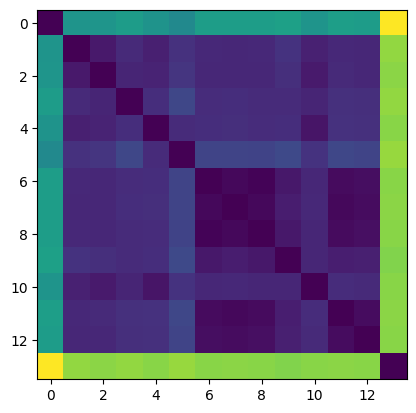

In [ ]:
# Show the distance matrix 
plt.imshow(mean_diff.cpu().detach().numpy())

In [14]:
df_emb_diff = pd.DataFrame(mean_diff.cpu().detach().numpy())
df_emb_diff.to_csv("df_emb_diff.csv", index=False, header=keys)